문제1

In [81]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import DataFrame, read_excel, melt, pivot_table, merge
from scipy.stats import *

# 분산분석을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell

In [24]:
plt.rcParams['font.family']='AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size']=12
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.unicode_minus']=False

In [25]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/tree_weight.xlsx')
origin.head()

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


In [26]:
df = origin.reindex(columns=['group','weight'])
df

,group,weight
0,A,4.17
1,A,5.58
2,A,5.18
3,A,6.11
4,A,4.50
5,A,4.61
6,A,5.17
7,A,4.53
8,A,5.33
9,A,5.14


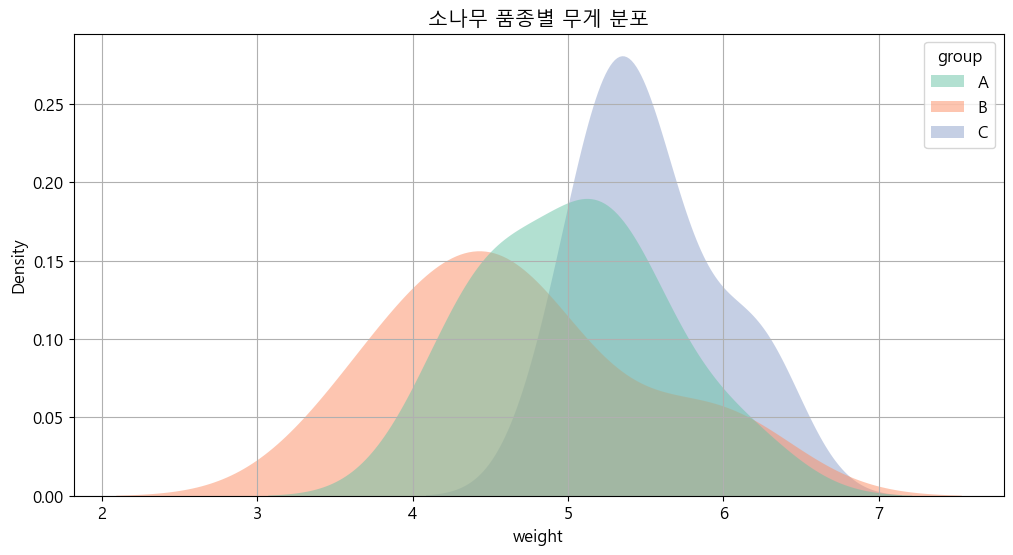

In [27]:
# 소나무 품종별 무게 분포 확인

sb.kdeplot(data = df, x = df['weight'], hue='group',palette='Set2',
            fill=True, alpha=.5, linewidth=0)
plt.grid()
plt.title('소나무 품종별 무게 분포')

plt.show()
plt.close()

In [28]:
# 데이터 전처리 할 필요가 없음

In [29]:
# 가설검정의 가정 확인

# 정규성

품종 = df['group'].unique()
품종

for i in 품종:
    data = df[df['group'] == i]['weight']
    s, p = normaltest(data)
    print('[{0}] statistic: {1}, p-value: {2}, 정규성 충족 여부: {3}'.format(i,s,p,p > 0.05))
    

[A] statistic: 0.23349562890737596, p-value: 0.8898095619814377, 정규성 충족 여부: True
[B] statistic: 0.9677406201467389, p-value: 0.616393136709484, 정규성 충족 여부: True
[C] statistic: 1.0131772587138148, p-value: 0.6025475898963044, 정규성 충족 여부: True


In [30]:
# 등분산성 확인

fields = []

for i in 품종:
    data = df[df['group'] == i]['weight']
    fields.append(data)
s, p = bartlett(*fields)
print('statistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))



statistic: 2.879, p-value: 0.237, 등분산성 충족 여부: True


In [31]:
# 일원분산분석 수행

lm = ols('weight ~ C(group)', data=df).fit()
anova = anova_lm(lm)
print(anova)

            df    sum_sq   mean_sq         F   PR(>F)
C(group)   2.0   3.76634  1.883170  4.846088  0.01591
Residual  27.0  10.49209  0.388596       NaN      NaN


In [32]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')


'statistic: 4.846, p-value: 0.016, 대립가설 채택'

In [33]:
# 사후검정
# 등분산이고 샘플수가 다르기 대문에 본페로니 교정 사용

comp = MultiComparison(df['weight'], df['group'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]



group1,group2,stat,pval,pval_corr,reject
A,B,1.1913,0.249,0.7471,False
A,C,-2.134,0.0469,0.1406,False
B,C,-3.0101,0.0075,0.0226,True


>본페로니 교정 결과 A,B와 A,C의 평균은 통계적으로 차이가 없고 B,C의 평균은 통계적으로 유의미한 차이가 있다.(p<=0.05)

문제2

In [34]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/poisons.xlsx')
origin

,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1
...,...,...,...
355,4.7,P3,T4
356,4.9,P3,T4
357,4.9,P3,T4
358,4.5,P3,T4


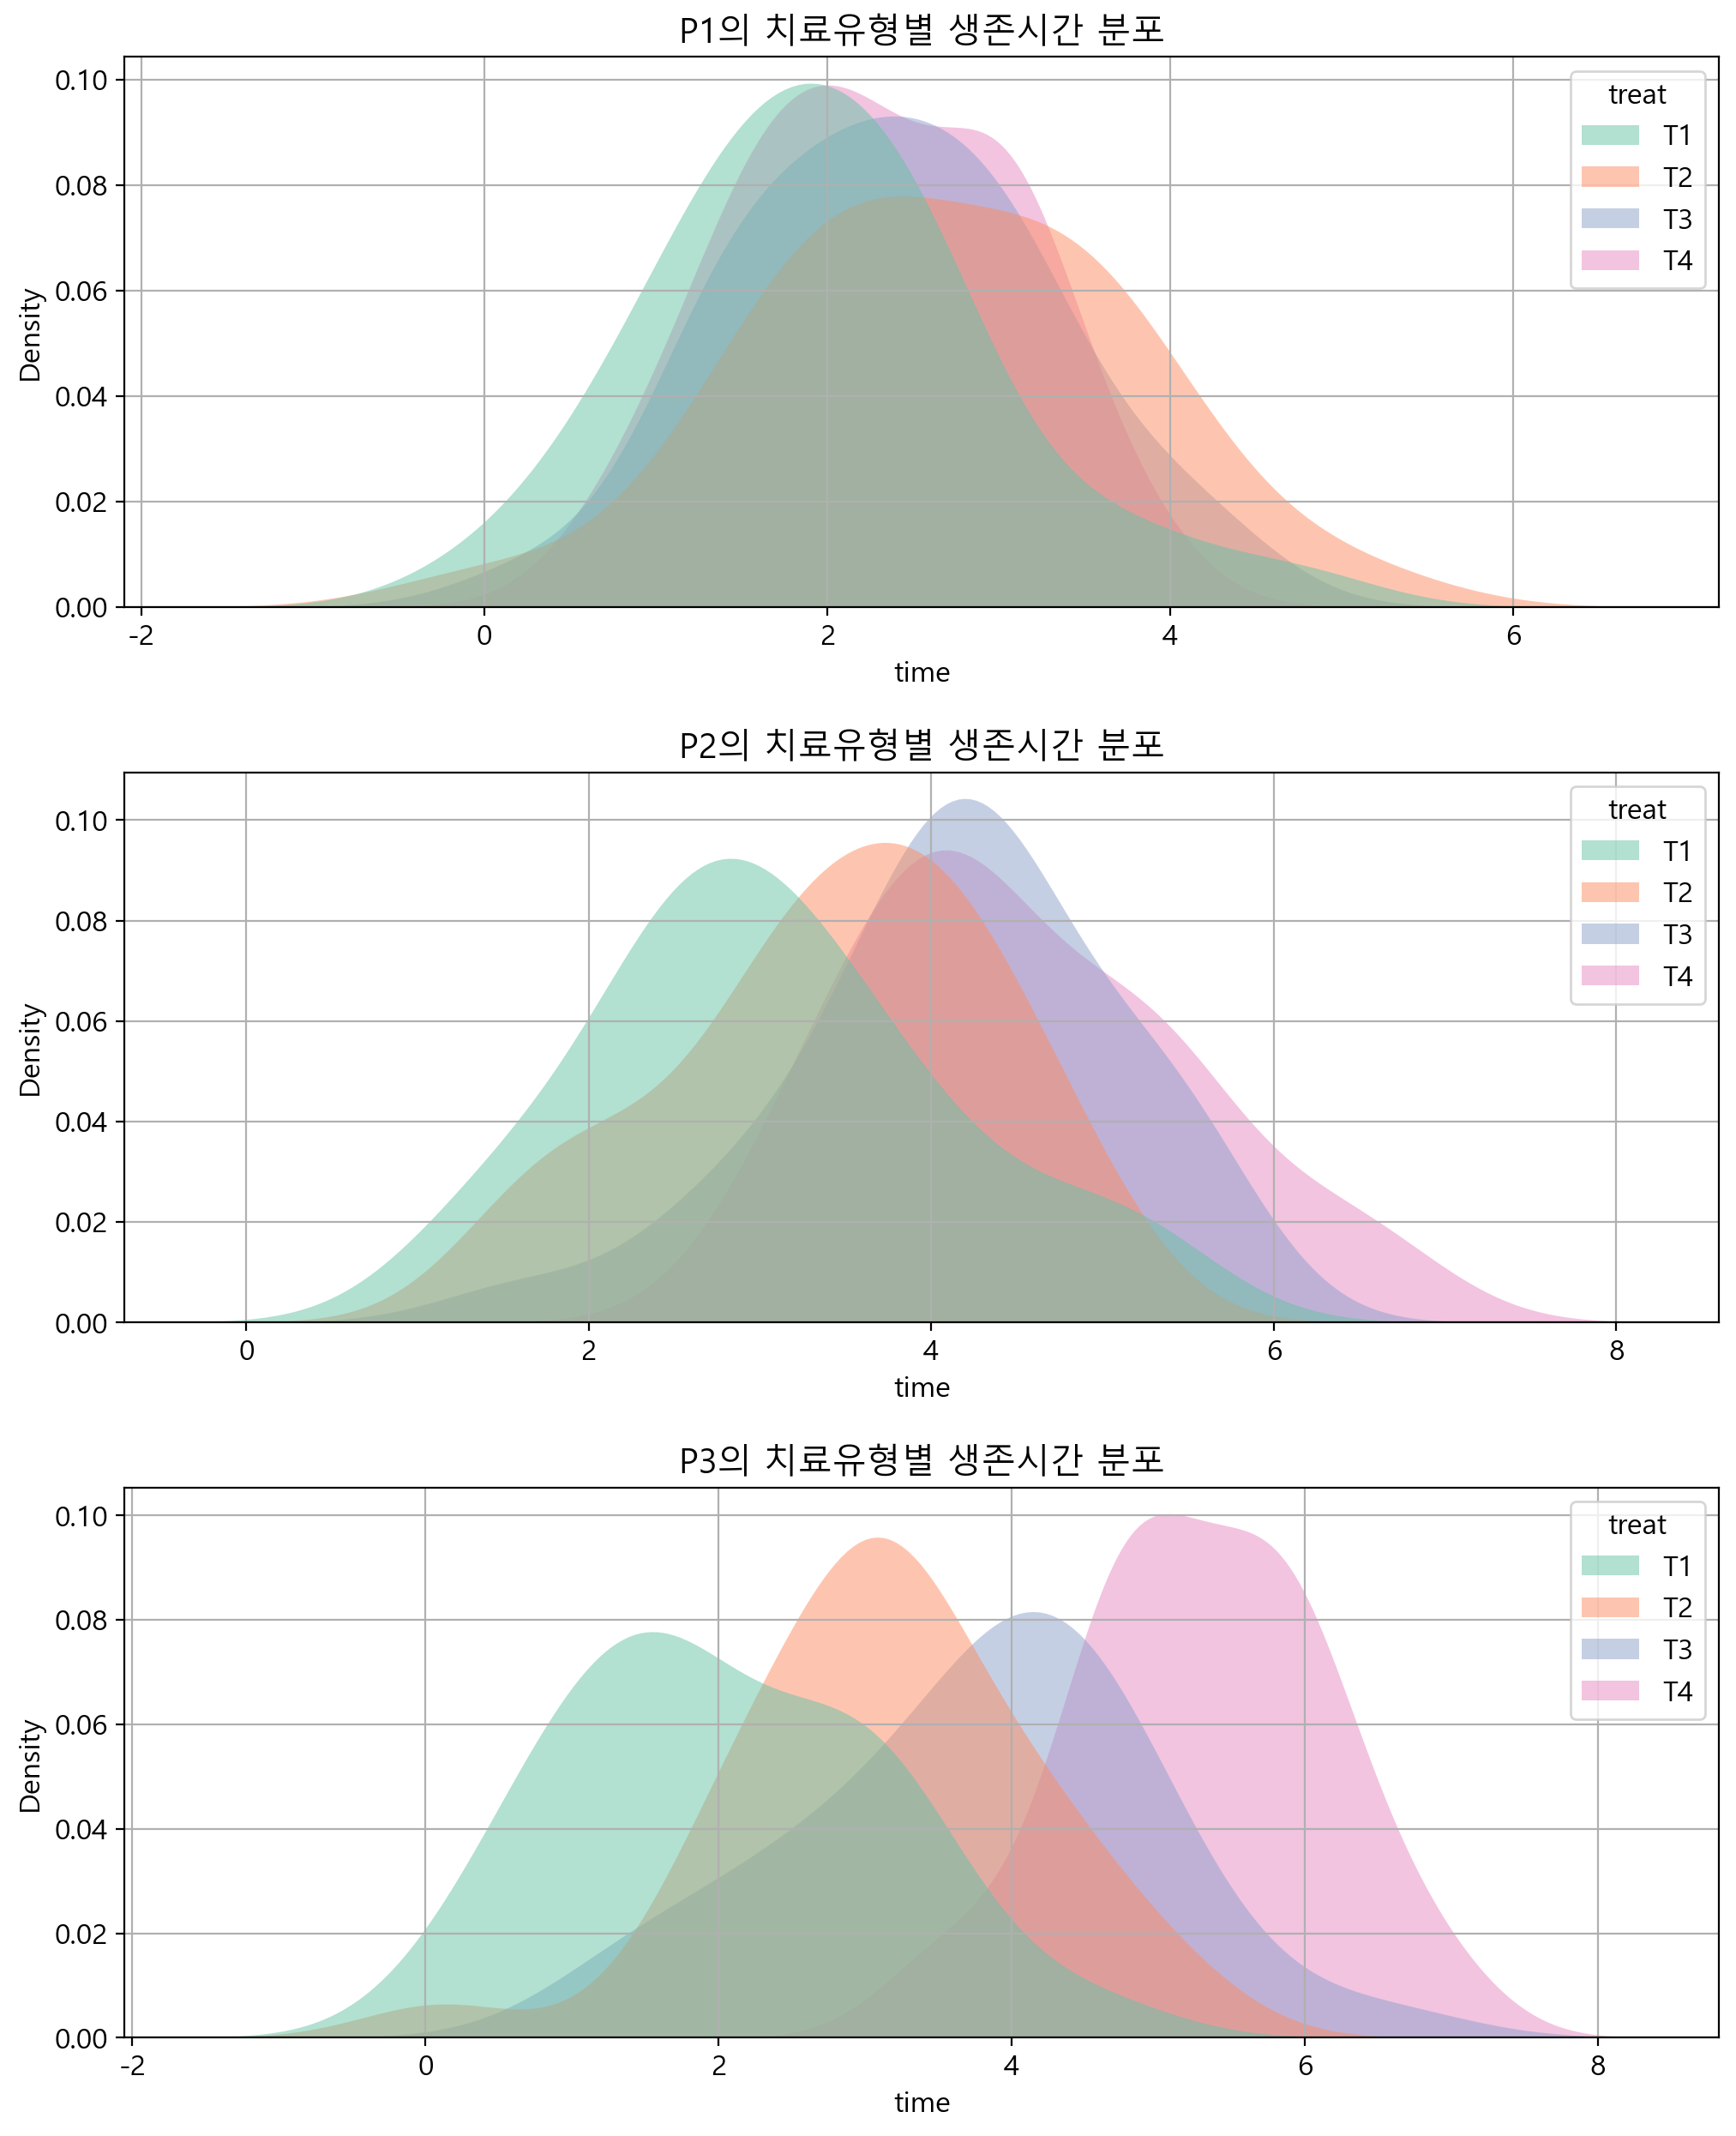

In [35]:
독극물 = origin['poison'].unique()
독극물

fig, ax = plt.subplots(3,1, figsize =(12,15),dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(독극물):
    sb.kdeplot(data = origin, x=origin[origin['poison']==v]['time'], hue='treat', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=ax[i])
    ax[i].grid()
    ax[i].set_title('%s의 치료유형별 생존시간 분포' % 독극물[i])


plt.show()
plt.close()

In [36]:
# 가설검정 정규성

치료유형 = origin['treat'].unique()
치료유형
size = len(치료유형)
size

4

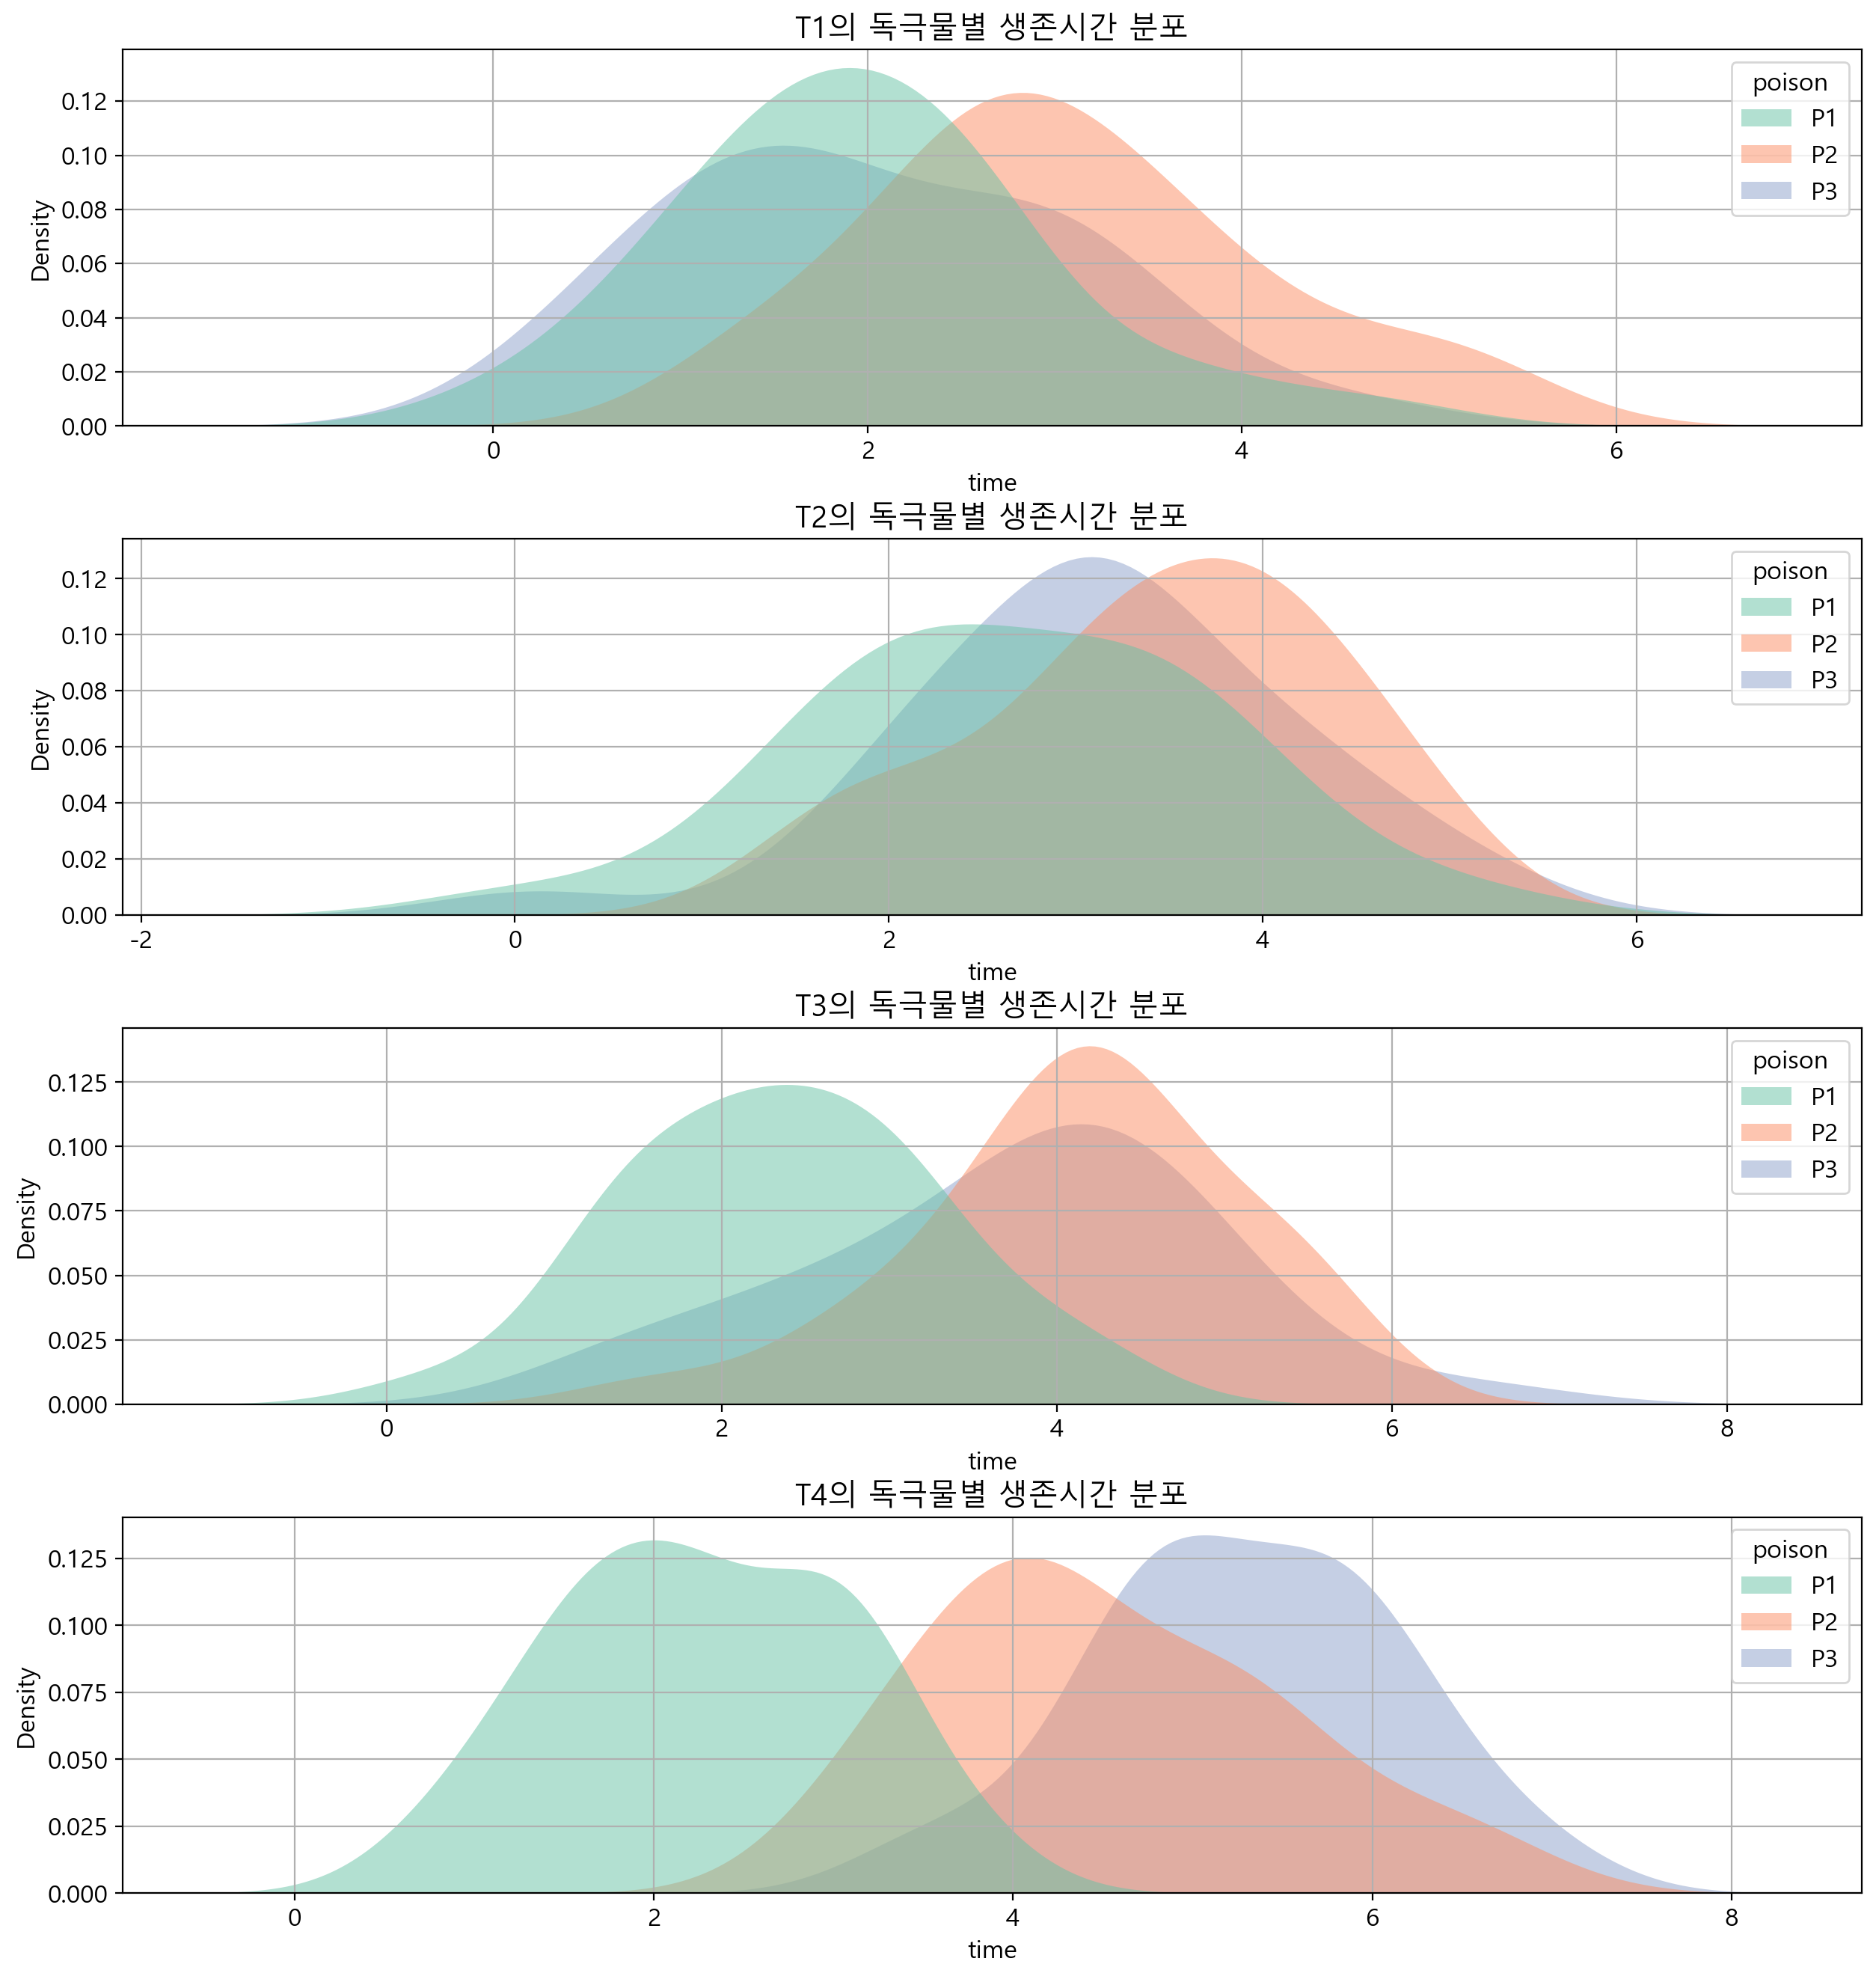

In [37]:
fig, ax = plt.subplots(size,1, figsize =(15,4*size),dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, t in enumerate(치료유형):
    sb.kdeplot(data = origin, x=origin[origin['treat']==t]['time'], hue='poison', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=ax[i])
    ax[i].grid()
    ax[i].set_title('%s의 독극물별 생존시간 분포' % 치료유형[i])


plt.show()
plt.close()

In [38]:
data = origin.copy()
xname = ['poison', 'treat']
yname = 'time'

equal_var_fields = []
normal_dist = True
report = []

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field" : '{0}, {1}'.format(i, j),
            "statistic" : s,
            'p-value': p,
            'result' : normalize
            
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "bartlett"
    s, p = bartlett(*equal_var_fields)
else: 
    n = 'levene'
    s, p = levene(*equal_var_fields)

report.append({
            "field" : n,
            "statistic" : s,
            'p-value': p,
            'result' : p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


In [39]:
for i in 독극물:
    for j in 치료유형:
        data = origin[(origin['poison'] == i) & (origin['treat']==j)]['time']
        s, p = shapiro(data)
        print('[{0} + {1}] statistic: {2}, p-value: {3}, 정규성 충족 여부: {4}'.format(i,j,s,p, p > 0.05 ))

[P1 + T1] statistic: 0.9702048897743225, p-value: 0.5447965860366821, 정규성 충족 여부: True
[P1 + T2] statistic: 0.9914728403091431, p-value: 0.9965269565582275, 정규성 충족 여부: True
[P1 + T3] statistic: 0.9875459671020508, p-value: 0.9723297357559204, 정규성 충족 여부: True
[P1 + T4] statistic: 0.9705753922462463, p-value: 0.5550379157066345, 정규성 충족 여부: True
[P2 + T1] statistic: 0.9671317934989929, p-value: 0.4639676511287689, 정규성 충족 여부: True
[P2 + T2] statistic: 0.9593607187271118, p-value: 0.2983076274394989, 정규성 충족 여부: True
[P2 + T3] statistic: 0.9666032195091248, p-value: 0.45088282227516174, 정규성 충족 여부: True
[P2 + T4] statistic: 0.9609524011611938, p-value: 0.32755979895591736, 정규성 충족 여부: True
[P3 + T1] statistic: 0.9795524477958679, p-value: 0.8135296702384949, 정규성 충족 여부: True
[P3 + T2] statistic: 0.9681426882743835, p-value: 0.4896875321865082, 정규성 충족 여부: True
[P3 + T3] statistic: 0.9781067967414856, p-value: 0.7732904553413391, 정규성 충족 여부: True
[P3 + T4] statistic: 0.9870960116386414, p-value: 0.

In [40]:
# 등분산성

fields = []

for i in 독극물:
    for j in 치료유형:
        data = origin[(origin['poison'] == i) & (origin['treat']==j)]['time']
        fields.append(data)

s, p = bartlett(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 8.154, p-value: 0.699, 등분산성 충족 여부: True


In [41]:
# 분산분석 수행
# 전처리

formula = 'time ~ C(poison)*C(treat)'
lm = ols(formula, origin).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(poison),2.0,148.976389,74.488194,74.722166,1.002877e-27
C(treat),3.0,131.260972,43.753657,43.891090,4.430485e-24
C(poison):C(treat),6.0,81.381611,13.563602,13.606206,6.938981e-14
Residual,348.0,346.910333,0.996869,NaN,NaN


> 독극물에 대한 p값은 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.
>
> 치료방법에 대한 p값 역시 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.
>
> 하지만 독극물과 치료방법에 대한 p값은 0.05보다 크기 때문에 독극물과 치료방법에는 연관성이 없다고 할 수 있다.

문제3

In [42]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/tomato.xlsx')
origin['효소함량'] = origin['효소함량'].astype('str')
origin

,효소함량,모종성장
0,0,10.8
1,0,9.1
2,0,13.5
3,0,9.2
4,1000,11.1
5,1000,11.2
6,1000,8.2
7,1000,11.3
8,5000,5.4
9,5000,4.6


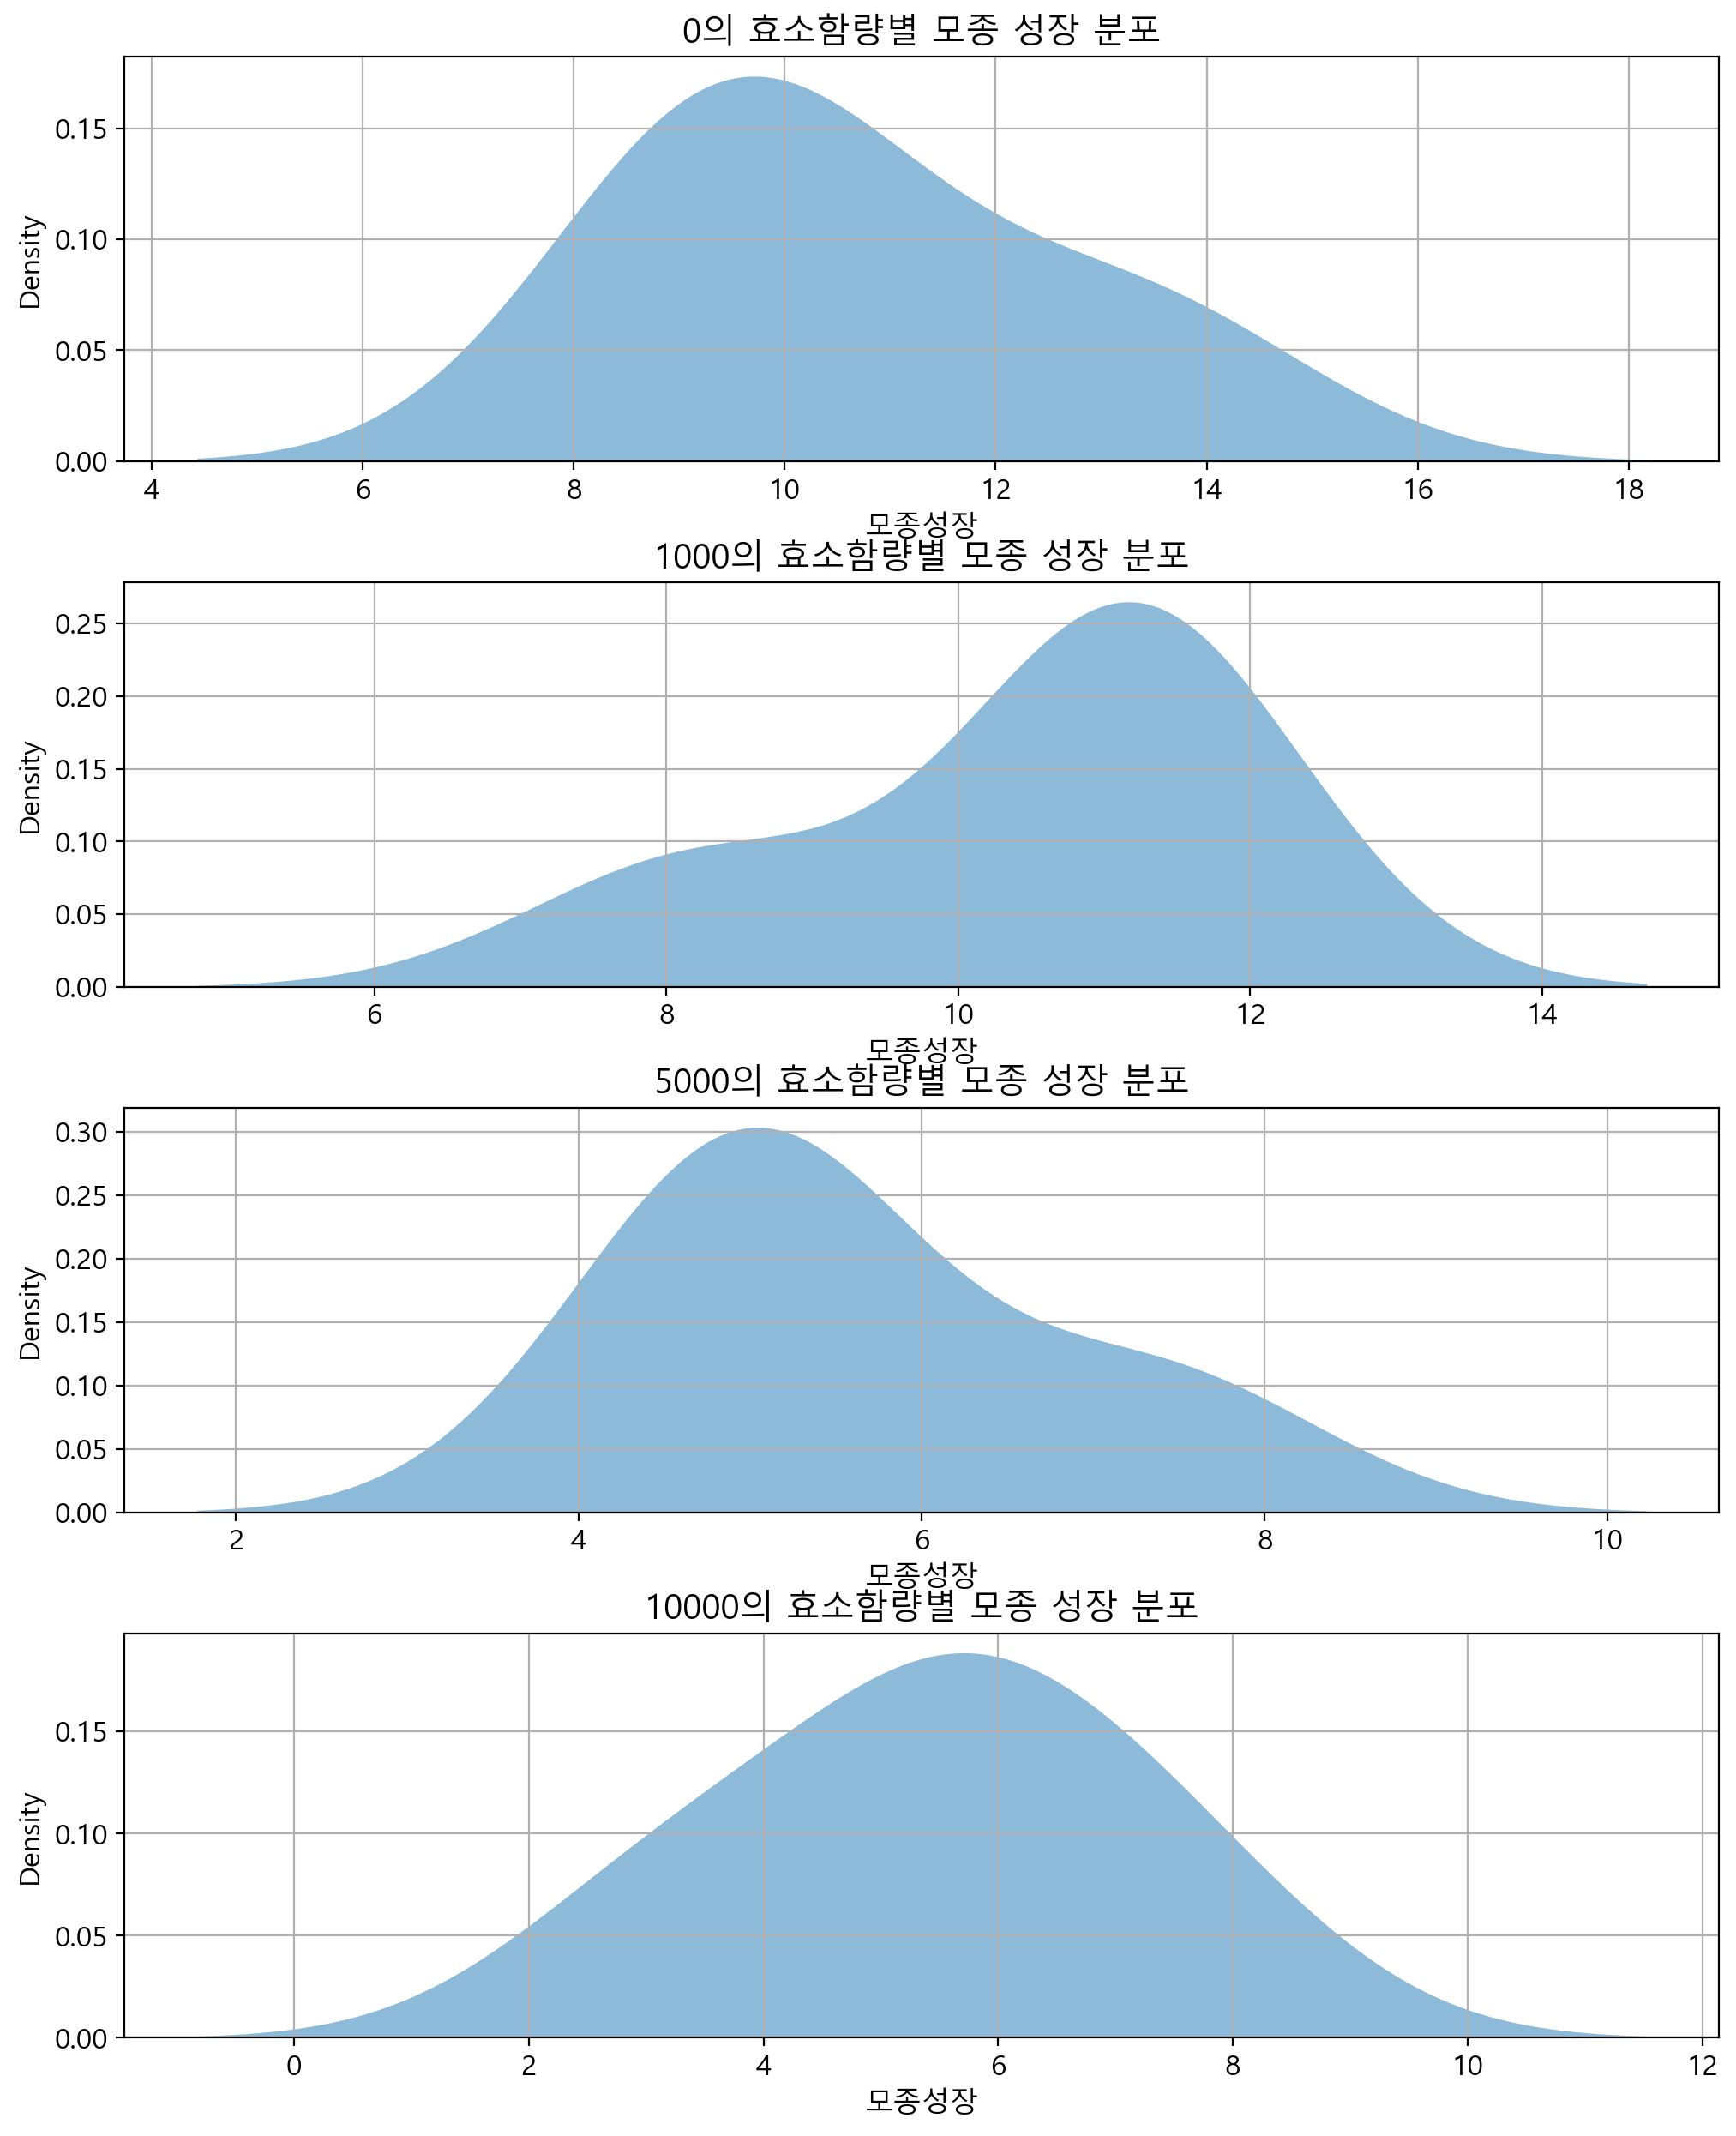

In [43]:
# 효소 함량별 모종성장 분포 확인

효소함량 = origin['효소함량'].unique()

size = len(효소함량)

fig, ax = plt.subplots(size,1, figsize =(12,15),dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    sb.kdeplot(data = origin, x=origin[origin['효소함량'] == 효소함량[i]]['모종성장'], palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title('%s의 효소함량별 모종 성장 분포' % 효소함량[i])

plt.show()
plt.close()

In [44]:
for i in 효소함량:
    data = origin[origin['효소함량'] == i ]['모종성장']
    s, p = shapiro(data)
    print('[{0}] statistic: {1}, p-value: {2}, 정규성 충족 여부: {3}'.format(i,s,p, p > 0.05 ))

[0] statistic: 0.8557126522064209, p-value: 0.24520312249660492, 정규성 충족 여부: True
[1000] statistic: 0.6809845566749573, p-value: 0.006817735731601715, 정규성 충족 여부: False
[5000] statistic: 0.8542200326919556, p-value: 0.24012230336666107, 정규성 충족 여부: True
[10000] statistic: 0.9810734391212463, p-value: 0.9082873463630676, 정규성 충족 여부: True


In [45]:
# 정규성이 충족되지 않을 때 levene 등분산성 검정

fields = []

for i in 효소함량:
    data = origin[origin['효소함량'] == i ]['모종성장']
    fields.append(data)

s, p = levene(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 0.310, p-value: 0.818, 등분산성 충족 여부: True


In [46]:
lm = ols('모종성장 ~ C(효소함량)', data=origin).fit()
anova = anova_lm(lm)
print(anova)

            df    sum_sq    mean_sq          F    PR(>F)
C(효소함량)    3.0  101.1275  33.709167  12.085748  0.000615
Residual  12.0   33.4700   2.789167        NaN       NaN


In [47]:
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 12.086, p-value: 0.001, 대립가설 채택'

> 효소함량에 대한 p값은 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.

사후검정

In [48]:
# 등분산이 아니므로 Games Howell 사용

result = pairwise_gameshowell(origin, dv='모종성장', between='효소함량')
result


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0,1000,10.65,10.45,0.20,1.272137,0.157216,5.496136,0.998446,0.096668
1,0,10000,10.65,5.45,5.20,1.355852,3.835228,5.873304,0.033852,2.358188
2,0,5000,10.65,5.60,5.05,1.200347,4.207116,4.939807,0.031145,2.586852
3,1000,10000,10.45,5.45,5.00,1.161178,4.305974,5.844407,0.020690,2.647638
4,1000,5000,10.45,5.60,4.85,0.975107,4.973814,5.797948,0.010876,3.058276
5,10000,5000,5.45,5.60,-0.15,1.082051,-0.138626,5.379904,0.998929,-0.085238


> 효소함량에 대한 p값은 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.
> 0, 1000과 10000, 5000은 p값이 0.05보다 크므로 통계적으로 유의한 차이가 있고 나머지는 통계적으로 유의한 차이가 없다고 볼 수 있다.

문제4

In [49]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/reading.xlsx')
origin

,독서방법,점수
0,B,6
1,B,9
2,B,2
3,B,16
4,D,7
5,D,7
6,D,12
7,D,10
8,D,16
9,S,11


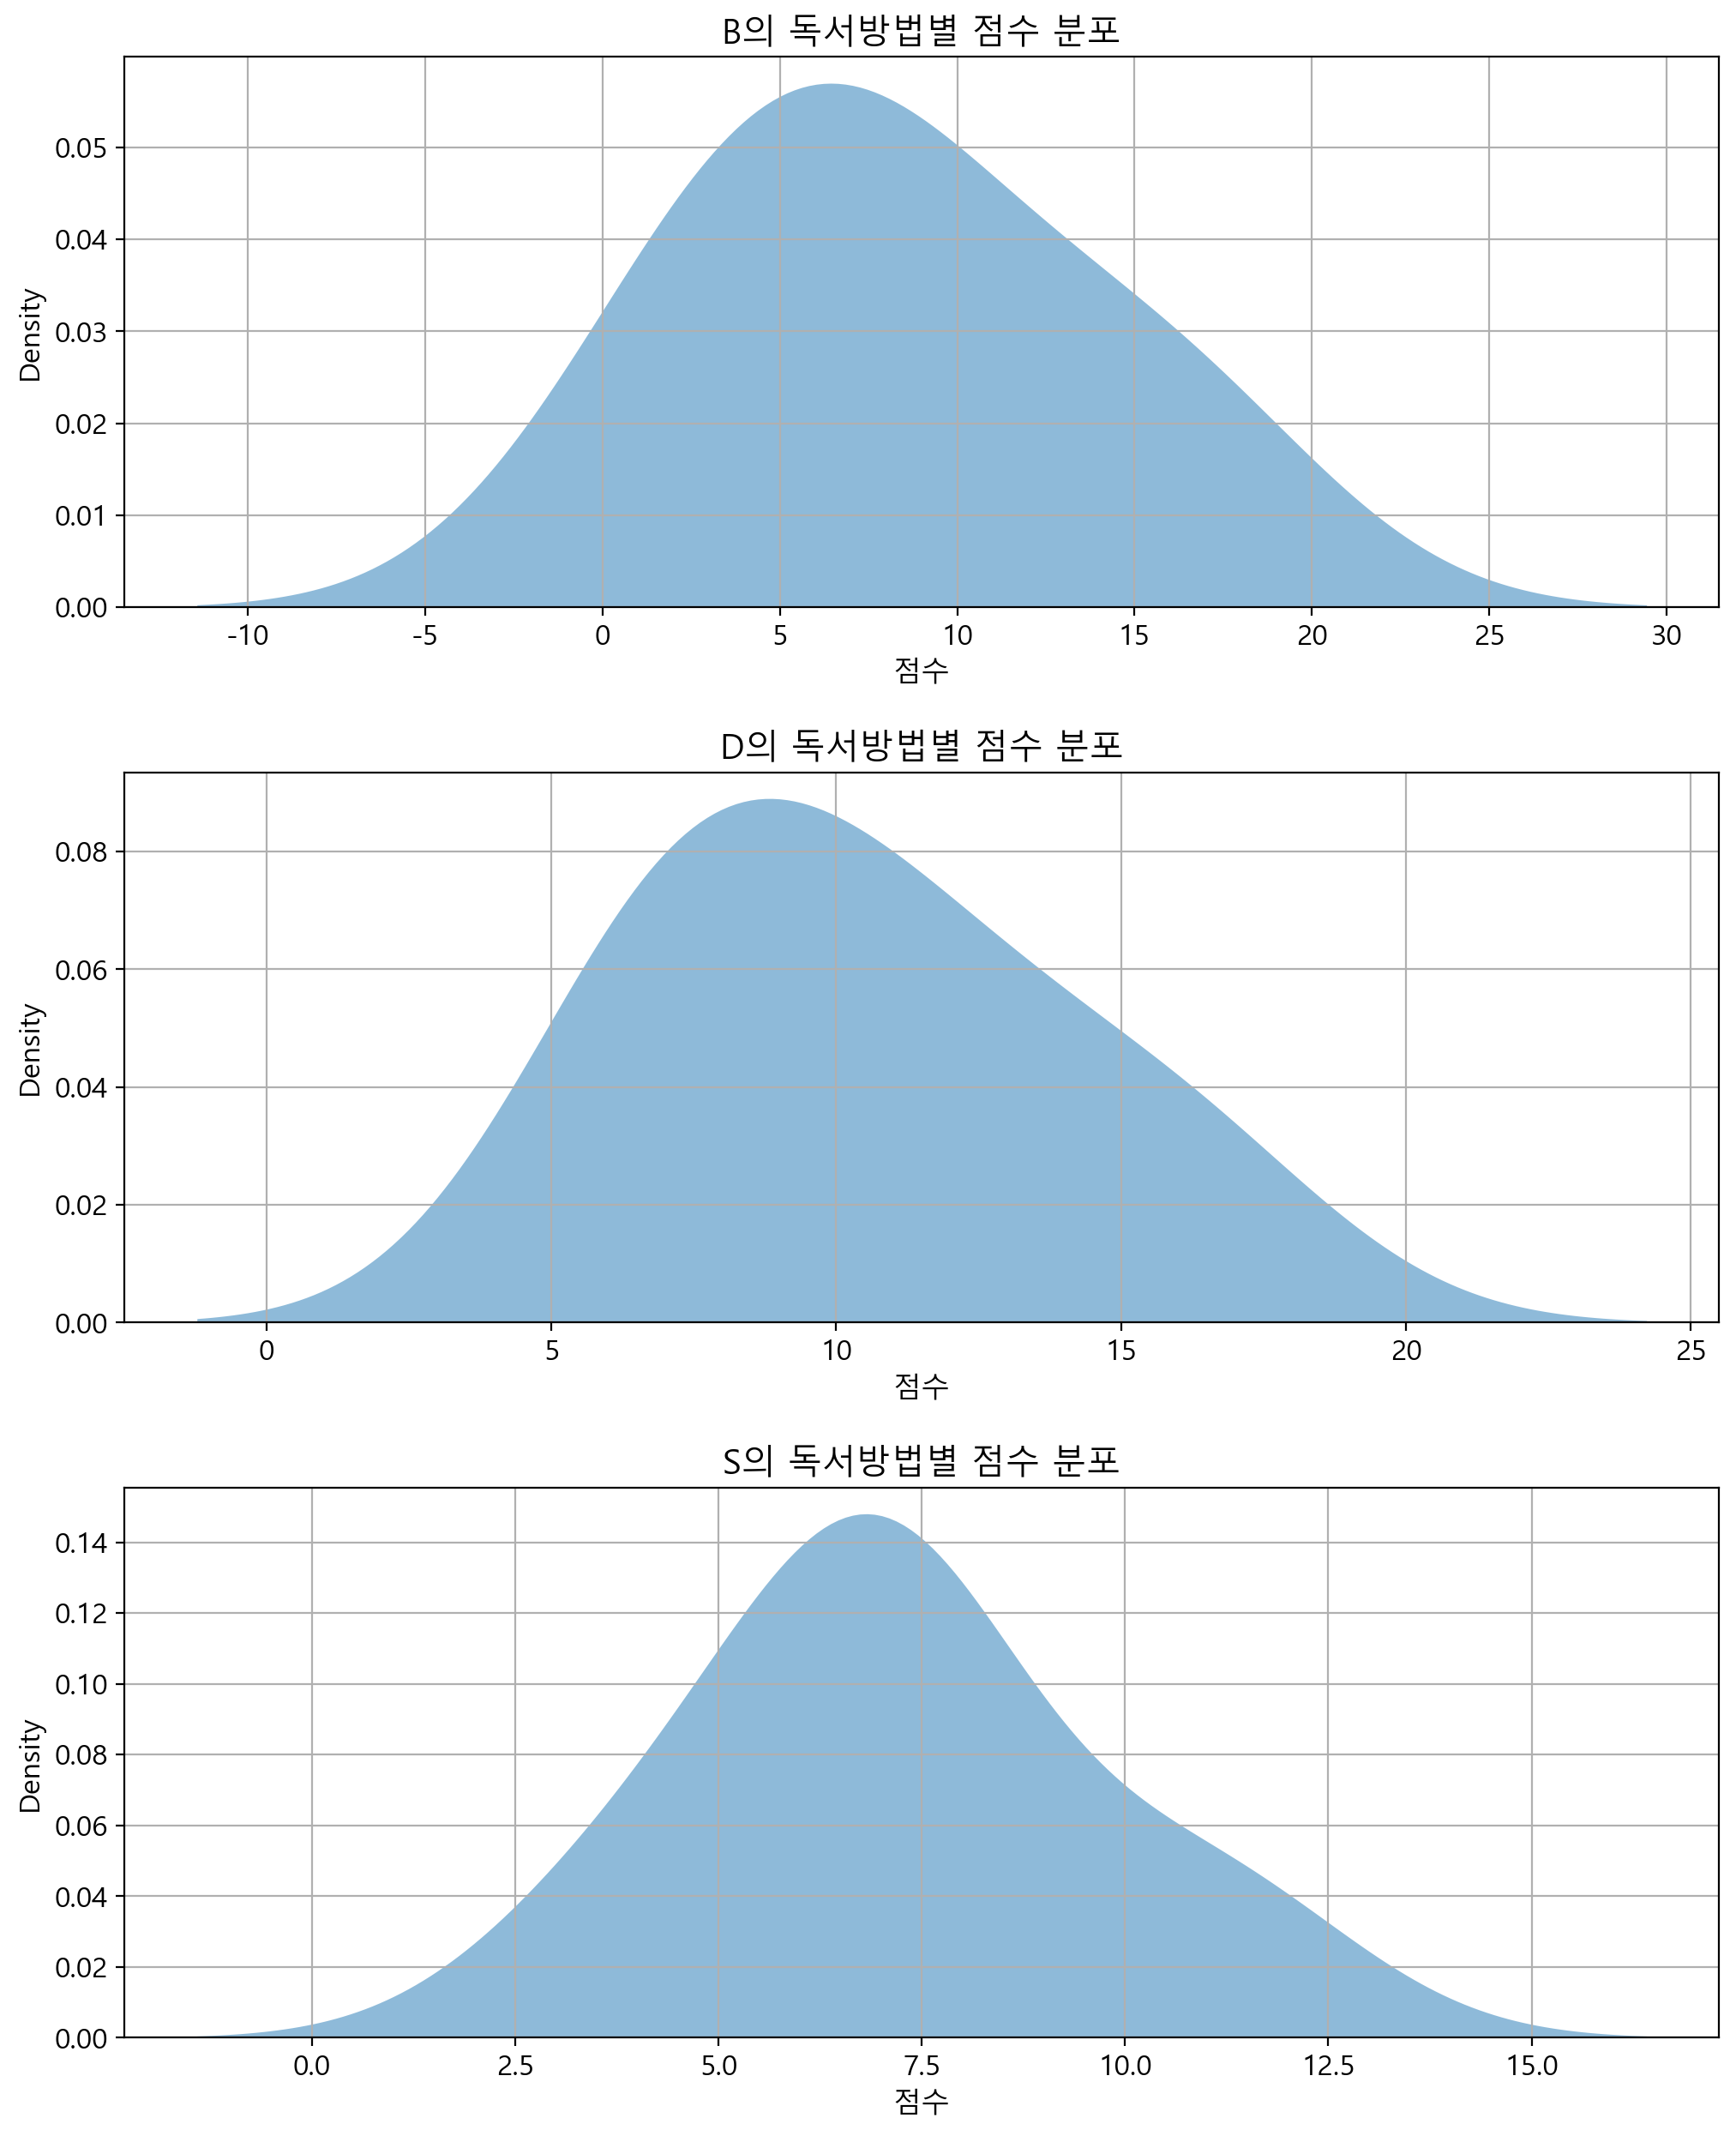

In [50]:
# 독서방법별 점수 분포 확인

독서방법 = origin['독서방법'].unique()

size = len(독서방법)

fig, ax = plt.subplots(size,1, figsize =(12,15),dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    sb.kdeplot(data = origin, x=origin[origin['독서방법'] == 독서방법[i]]['점수'], palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title('%s의 독서방법별 점수 분포' % 독서방법[i])

plt.show()
plt.close()

In [51]:
# 정규성 충족 확인

for i in 독서방법:
    data = origin[origin['독서방법'] == i ]['점수']
    s, p = shapiro(data)
    print('[{0}] statistic: {1}, p-value: {2}, 정규성 충족 여부: {3}'.format(i,s,p, p > 0.05 ))

[B] statistic: 0.9778401255607605, p-value: 0.8892413973808289, 정규성 충족 여부: True
[D] statistic: 0.9034143686294556, p-value: 0.4290435016155243, 정규성 충족 여부: True
[S] statistic: 0.8728033304214478, p-value: 0.27796125411987305, 정규성 충족 여부: True


In [52]:
# 정규성이 충족되므로  bartlett 등분산성 검정

fields = []

for i in 독서방법:
    data = origin[origin['독서방법'] == i ]['점수']
    fields.append(data)

s, p = bartlett(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 2.271, p-value: 0.321, 등분산성 충족 여부: True


In [53]:
s, p = f_oneway(origin[origin['독서방법'] == 'B']['점수'], origin[origin['독서방법'] == 'D']['점수'],origin[origin['독서방법'] == 'S']['점수'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 0.779, p-value: 0.482, 귀무가설 채택'

`p-value`가 0.05보다 크므로 대립가설을 기각하고 귀무가설을 채택한다.

즉, 독서방법별 점수 차이는 통계적으로 유의하지 않다.

문제5

In [54]:
origin5 = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/edu.xlsx')
origin5

,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65
5,1,69,70
6,1,55,79
7,1,76,80
8,1,77,76
9,1,70,90


In [55]:
# 데이터 재구조화

df5 = melt(origin5, id_vars='교육방법',
          value_vars=['국어','영어'],
          var_name='과목',
          value_name='점수'
          )
df5

,교육방법,과목,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81
5,1,국어,69
6,1,국어,55
7,1,국어,76
8,1,국어,77
9,1,국어,70


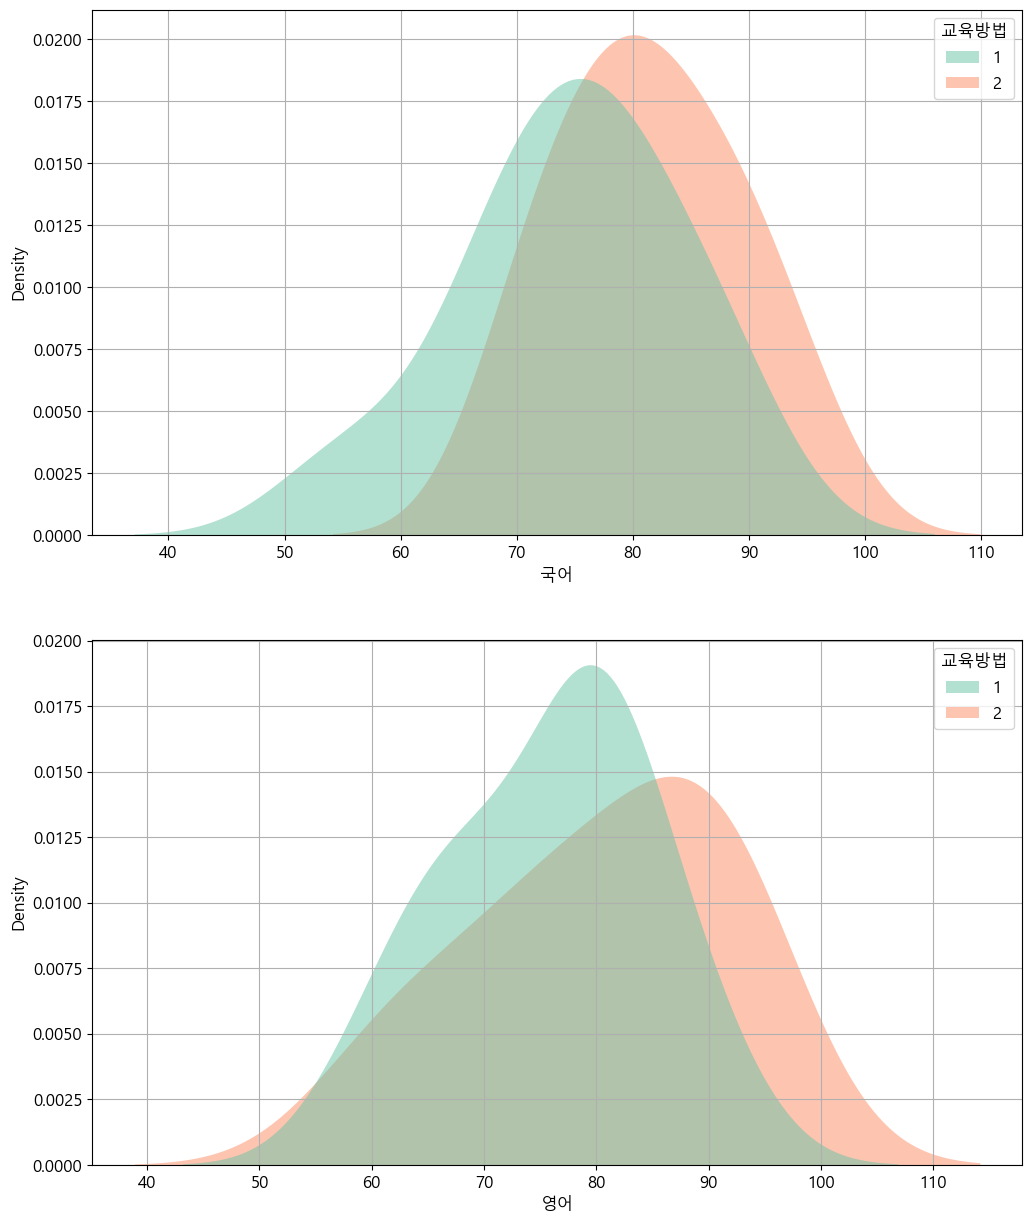

In [56]:
# 교육방법이 국어, 영어점수에 미치는 영향 비교

fields = ['국어', '영어']
fig, ax = plt.subplots(2, 1, figsize = (12,15))

for i, v in enumerate(ax):
    
    sb.kdeplot(data=origin5, x=fields[i], hue='교육방법',palette='Set2',
               fill = True, alpha=.5, linewidth=0, ax=v)
    v.grid()


plt.show()
plt.close()

In [57]:
# 정규성 확인

교육방법 = df5['교육방법'].unique()
s = len(교육방법)
과목 = df5['과목'].unique()
k = len(과목)

In [58]:
for i in 교육방법:
    for j in 과목:
        data = df5[(df5['교육방법'] == i) & (df5['과목'] == j)]['점수']
        s, p = normaltest(data)
        print('[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}'.format(i,j,s,p,p >= 0.05))


[1 + 국어] statistic: 0.911, p-value: 0.634, 정규성 충족 여부: True
[1 + 영어] statistic: 0.389, p-value: 0.823, 정규성 충족 여부: True
[2 + 국어] statistic: 0.300, p-value: 0.861, 정규성 충족 여부: True
[2 + 영어] statistic: 1.095, p-value: 0.578, 정규성 충족 여부: True


In [59]:
# 등분산성 확인

# 정규성이 충족되므로  bartlett 등분산성 검정

fields = []

for i in 교육방법:
    for j in 과목:
        data = df5[(df5['교육방법'] == i) & (df5['과목'] == j)]['점수']
        fields.append(data)

s, p = bartlett(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 1.253, p-value: 0.740, 등분산성 충족 여부: True


In [60]:
#origin5.dtypes

df5_1 = origin5.query('교육방법 == 1')
df5_1

df5_2 = origin5.query('교육방법 == 2')
df5_2 = df5_2.rename(columns={'국어':'국어2', '영어':'영어2'}).reset_index(drop=True)
df5_2

tdf5 = merge(df5_1,df5_2,left_index=True,right_index=True,how='outer')
tdf5

,교육방법_x,국어,영어,교육방법_y,국어2,영어2
0,1,65,82,2,75,72
1,1,87,79,2,69,75
2,1,73,85,2,83,93
3,1,79,60,2,81,85
4,1,81,65,2,72,60
5,1,69,70,2,79,65
6,1,55,79,2,85,88
7,1,76,80,2,89,92
8,1,77,76,2,90,83
9,1,70,90,2,77,93


In [61]:
origin5
df5

,교육방법,과목,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81
5,1,국어,69
6,1,국어,55
7,1,국어,76
8,1,국어,77
9,1,국어,70


In [62]:
# 이원분산분석

formula = '점수 ~ C(교육방법_x)*C(교육방법_y)'
lm = ols(formula, df5).fit()
anova = anova_lm(lm, tpy=2)
anova

PatsyError: Error evaluating factor: NameError: name '교육방법_x' is not defined
    점수 ~ C(교육방법_x)*C(교육방법_y)
         ^^^^^^^^^

> 교육방법에 대한 p값은 0.05보다 크므로 통계적으로 유의한 차이가 없다고 할 수 있다.
>
> 과목에 대한 p값 역시 0.05보다 크므로 통계적으로 유의한 차이를 보인다고 할 수 없다.
>
> 교육방법과 과목에 대한 p값은 0.05보다 크기 때문에 교육방법과 과목간에는 연관성이 있다고 할 수 없다.

문제6

1) 상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.
   

In [63]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/E.InferentialStatistics/수업자료/commercial.xlsx')
origin.head()

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


In [64]:
# 데이터 정제

df = origin[['type', 'sales_amount']]
df.dtypes

type            object
sales_amount     int64
dtype: object

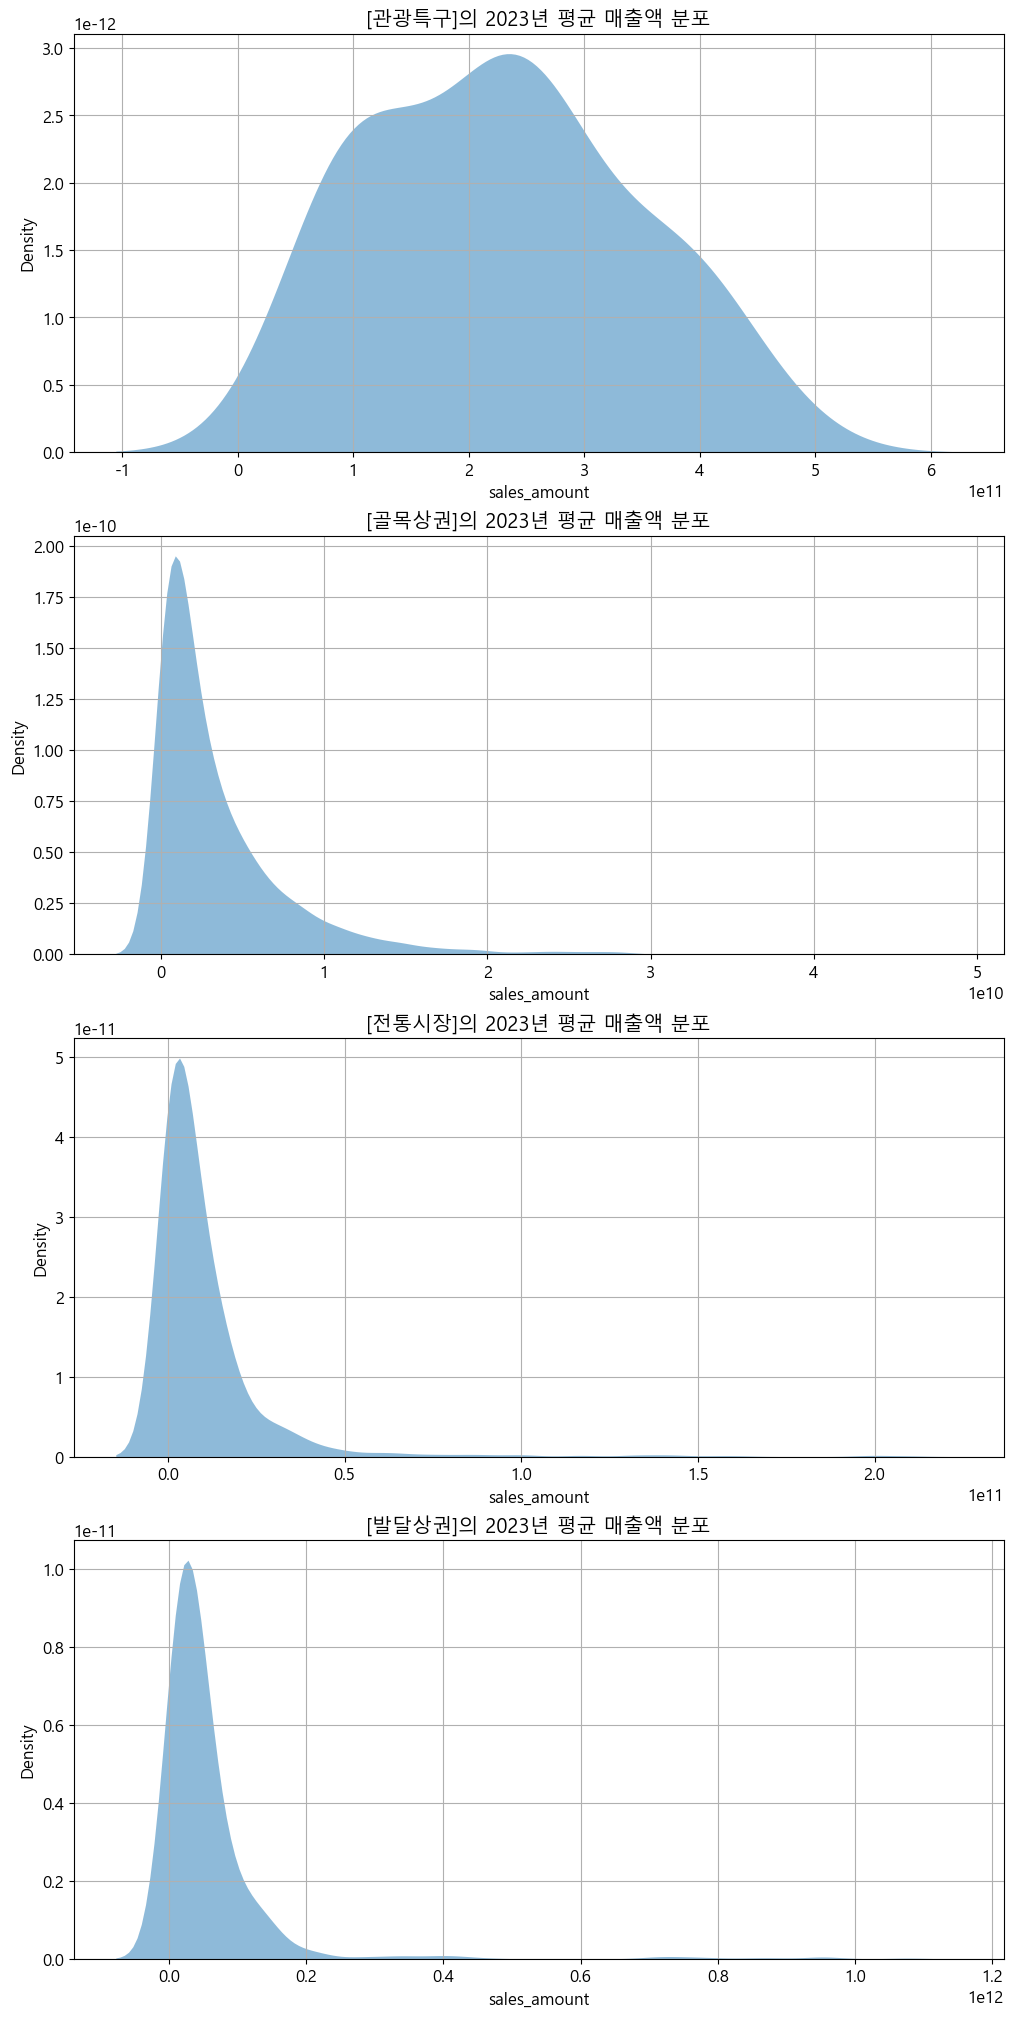

In [65]:
# 상권 종류별 2023년 평균 매출액 비교

fields = ['관광특구', '골목상권', '전통시장', '발달상권']
fig, ax = plt.subplots(4, 1, figsize = (12,25))

for i, v in enumerate(ax):
    
    sb.kdeplot(data=df, x= df[df['type']==fields[i]]['sales_amount'],palette='Set2',
               fill = True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title("[%s]의 2023년 평균 매출액 분포" % fields[i])


plt.show()
plt.close()

In [66]:
# 정규성 확인

상권종류 = df['type'].unique()

for i in 상권종류:

    data = df[(df['type'] == i)]['sales_amount']
    s, p = normaltest(data)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(i, s, p, p >= 0.05))

[관광특구] statistic: 2.023, p-value: 0.364, 정규성 충족 여부: True
[골목상권] statistic: 2949.769, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 1174.364, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 1194.780, p-value: 0.000, 정규성 충족 여부: False


In [67]:
# 정규성이 충족되지 않을 때 levene 등분산성 검정

fields = []

for i in 상권종류:
    ddata = df[(df['type'] == i)]['sales_amount']
    fields.append(data)

s, p = levene(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 0.000, p-value: 1.000, 등분산성 충족 여부: True


In [68]:
# 일원분산분석 

s, p = f_oneway(df[df['type'] == '골목상권']['sales_amount'], df[df['type'] == '전통시장']['sales_amount'],df[df['type'] == '관광특구']['sales_amount'],df[df['type'] == '발달상권']['sales_amount'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 612.137, p-value: 0.000, 대립가설 채택'

상권별 2023년 매출액 평균 차이가 통계적으로 유의미하다.

In [69]:
# 데이터 재구조화
df

,type,sales_amount
0,관광특구,72523644100
1,관광특구,283332346393
2,관광특구,81696730221
3,관광특구,212062656625
4,관광특구,231338386876
...,...,...
6217,전통시장,13523478306
6218,전통시장,6236556030
6219,전통시장,3973269286
6220,전통시장,15013907999


In [70]:
# 사후검정
# 등분산성 만족하고 샘플수가 동일하지 않으므로 본페로니 교정을 한다.

comp = MultiComparison(df['sales_amount'], df['type'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
골목상권,관광특구,-113.3793,0.0,0.0,True
골목상권,발달상권,-32.8487,0.0,0.0,True
골목상권,전통시장,-20.0738,0.0,0.0,True
관광특구,발달상권,7.9803,0.0,0.0,True
관광특구,전통시장,41.4036,0.0,0.0,True
발달상권,전통시장,14.6423,0.0,0.0,True


> 본페로니 교정 결과 상권별 평균은 통계적으로 유의미한 차이가 있다.(P<=0.05)

2) 상권 종류별로 2023년 분기별 평균 매출액은 어떤 차이가 보이는지 분석하라.

In [71]:
qdf = origin[['type','quarter','sales_amount']]
qdf

,type,quarter,sales_amount
0,관광특구,1,72523644100
1,관광특구,1,283332346393
2,관광특구,1,81696730221
3,관광특구,1,212062656625
4,관광특구,1,231338386876
...,...,...,...
6217,전통시장,4,13523478306
6218,전통시장,4,6236556030
6219,전통시장,4,3973269286
6220,전통시장,4,15013907999


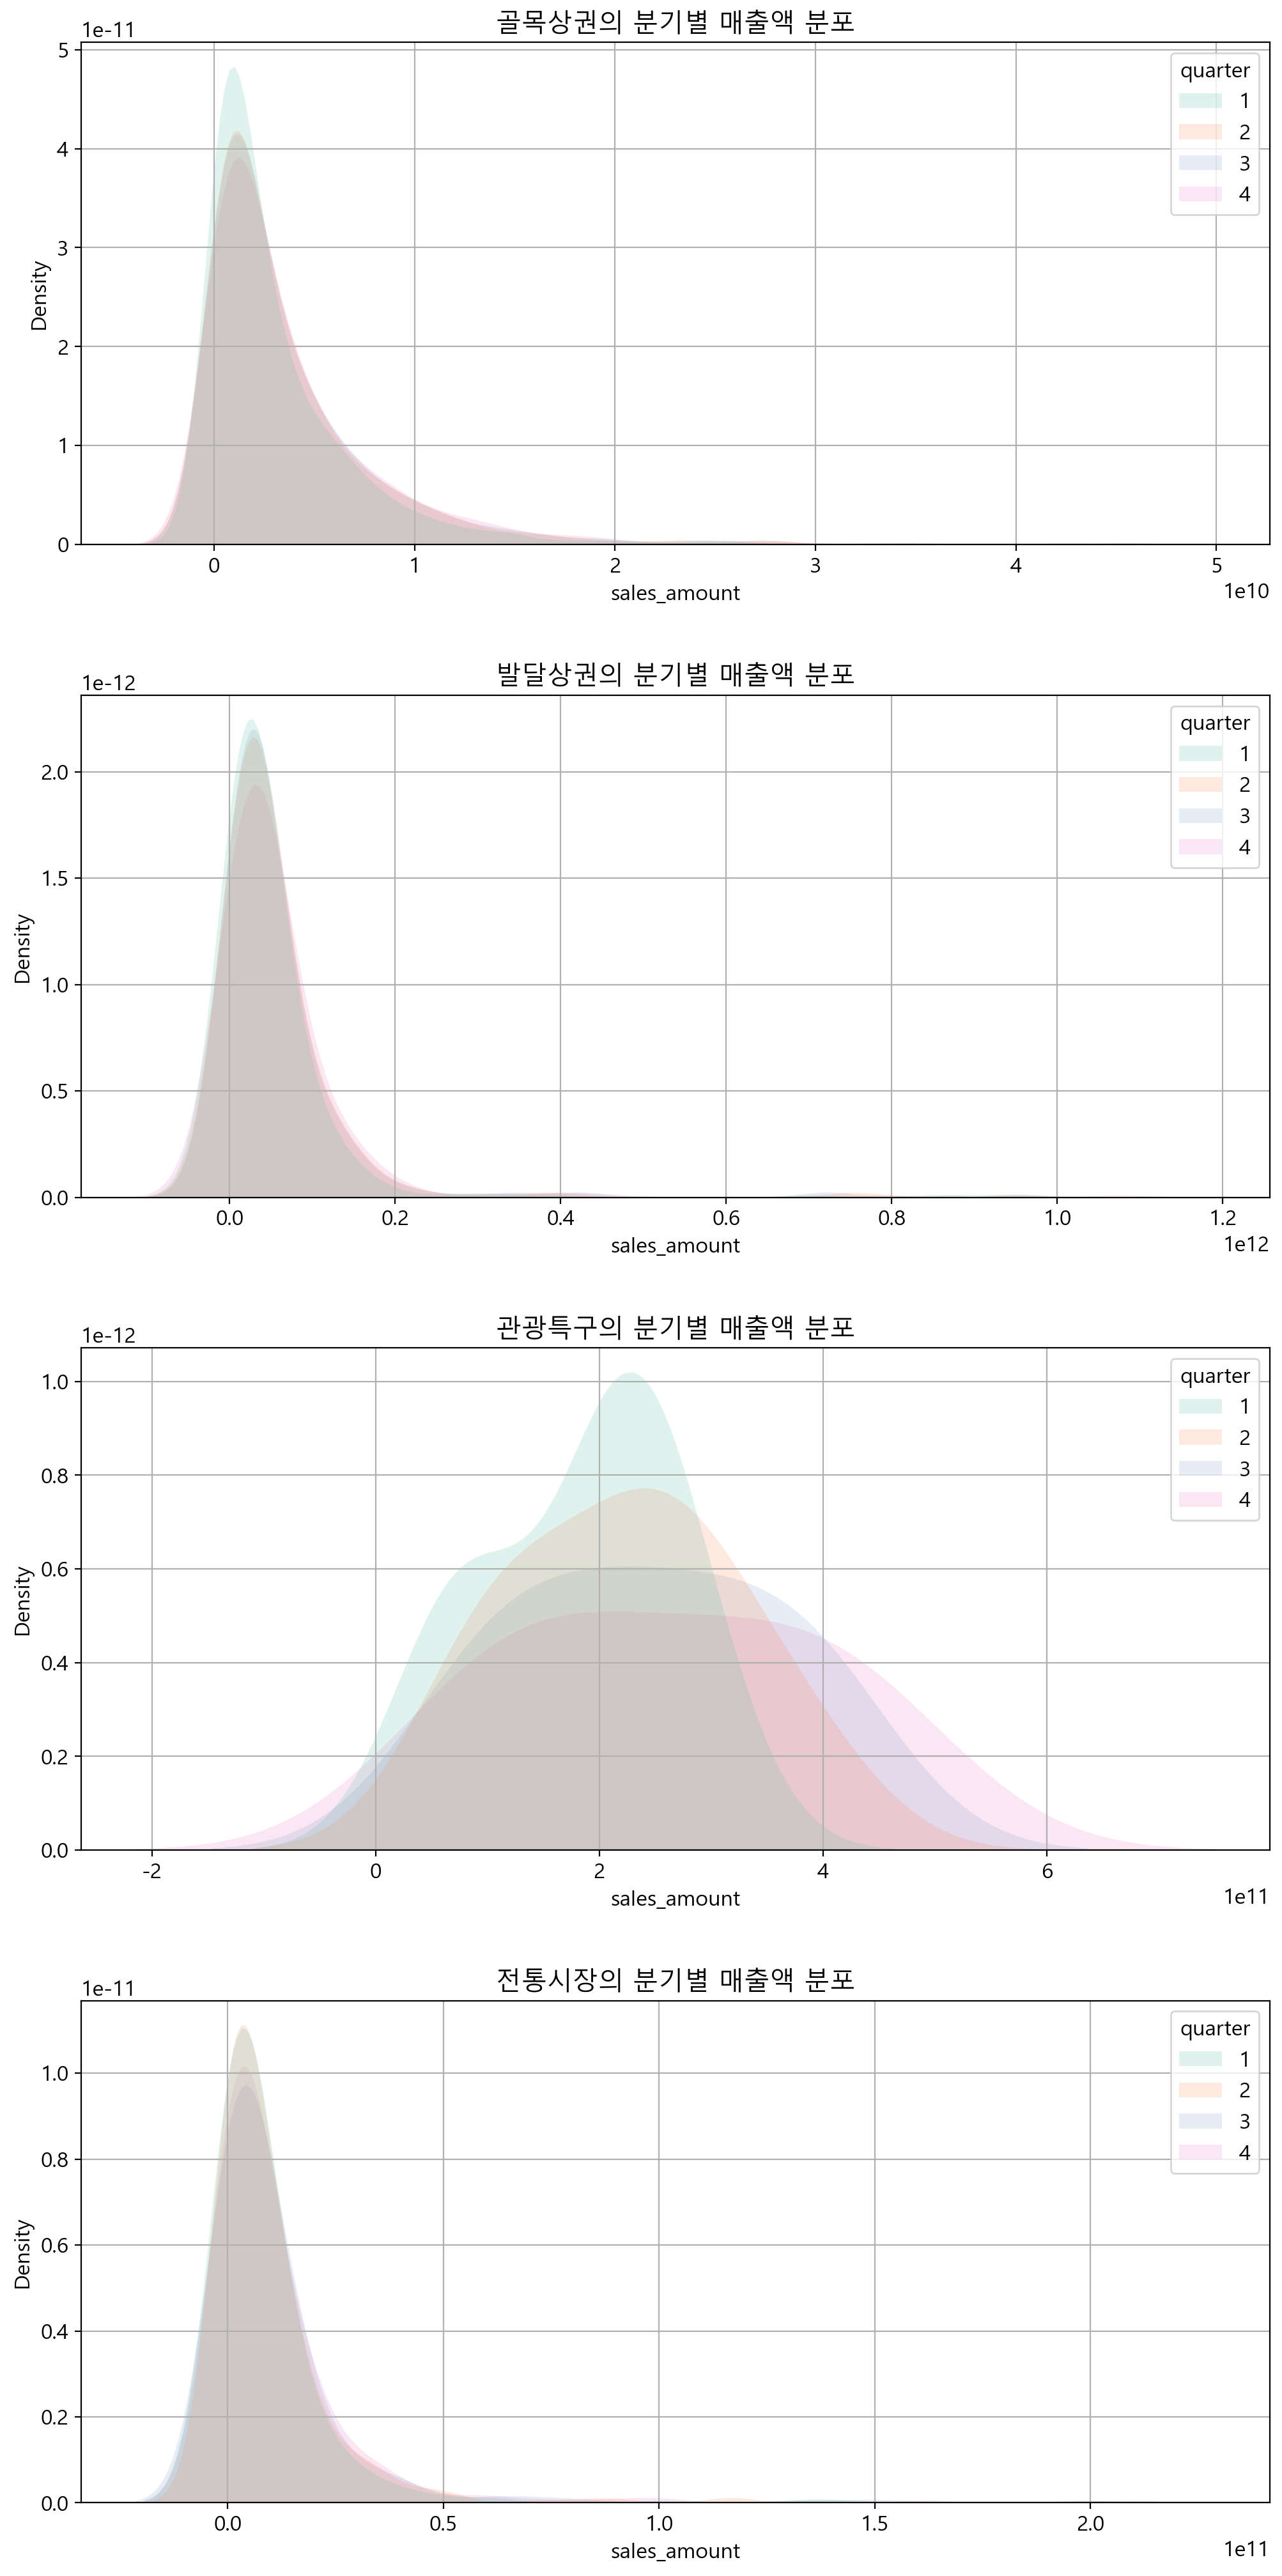

In [72]:
fields = ['골목상권', '발달상권', '관광특구', '전통시장']

fig, ax = plt.subplots(4,1, figsize =(12,25),dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    sb.kdeplot(data = qdf, x=qdf[qdf['type']==fields[i]]['sales_amount'], hue='quarter', palette='Set2',
               fill= True, alpha = 0.2, linewidth=0, ax=v)
    v.grid()
    v.set_title('%s의 분기별 매출액 분포' % fields[i])


plt.show()
plt.close()

In [73]:
qdf

,type,quarter,sales_amount
0,관광특구,1,72523644100
1,관광특구,1,283332346393
2,관광특구,1,81696730221
3,관광특구,1,212062656625
4,관광특구,1,231338386876
...,...,...,...
6217,전통시장,4,13523478306
6218,전통시장,4,6236556030
6219,전통시장,4,3973269286
6220,전통시장,4,15013907999


In [74]:
# 정규성 확인

상권종류 = qdf['type'].unique()
분기 = qdf['quarter'].unique()


for i in 상권종류:
    for j in 분기:
        data = qdf[(qdf['type'] == i) & (qdf['quarter'] == j)]['sales_amount']
        s, p = shapiro(data)
        print('[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}'.format(i,j,s,p,p >= 0.05))


[관광특구 + 1] statistic: 0.861, p-value: 0.191, 정규성 충족 여부: True
[관광특구 + 2] statistic: 0.927, p-value: 0.560, 정규성 충족 여부: True
[관광특구 + 3] statistic: 0.872, p-value: 0.236, 정규성 충족 여부: True
[관광특구 + 4] statistic: 0.946, p-value: 0.710, 정규성 충족 여부: True
[골목상권 + 1] statistic: 0.674, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 2] statistic: 0.687, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 3] statistic: 0.696, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 4] statistic: 0.669, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 1] statistic: 0.375, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 2] statistic: 0.431, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 3] statistic: 0.461, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 4] statistic: 0.409, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 1] statistic: 0.426, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 2] statistic: 0.537, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 3] statistic: 0.473, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 4] statistic: 0.522, p-value: 0.000, 정규성 충족 여부: False


In [75]:
# 등분산성 검정
# 정규성이 충족 안되므로 levene 검정


fields = []

for i in 상권종류:
    for j in 분기:
        data = qdf[(qdf['type'] == i) & (qdf['quarter'] == j)]['sales_amount']
        fields.append(data)

s, p = levene(*fields)
print('statisic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}'.format(s,p,p > 0.05))


statisic: 53.903, p-value: 0.000, 등분산성 충족 여부: False


In [76]:
#formula = '머리둘레 ~ C(태아번호)+C(측정자번호)+C(태아번호):C(측정자번호)'
formula = 'sales_amount ~ C(type)*C(quarter)'
lm = ols(formula, qdf).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(type),3.0,3.397583e+24,1.132528e+24,612.997343,0.000000
C(quarter),3.0,6.915692e+21,2.305231e+21,1.247740,0.290658
C(type):C(quarter),9.0,3.140937e+22,3.489930e+21,1.888976,0.048918
Residual,6206.0,1.146574e+25,1.847525e+21,NaN,NaN


> 상권종류에 대한 p값이 0.05보다 작으므로 상권종류에 따른 매출액의 평균은 통계적으로 유의미한 차이가 있다.
>
> 분기별에 대한 p값이 0.05보다 크므로 분기별에 따른 매출액의 평균은 통계적으로 유의미한 차이가 없다.
>
> 상권종류와 분기에 대한 p값이 0.05보다 작으므로 상권종류와 분기별 상호작용이 매출액에 교효작용이 있다고 볼 수 있다.